# 1. Data preparation

In [ ]:
# libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def data_prep():
    # read the D3 dataset
    df = pd.read_csv('D3.csv')

    #Correct data types for admission_type_id, discharge_disposition_id, admission_source_id
    #Changto interval/integer to nominal/str
    df['admission_type_id'] = df['admission_type_id'].astype(str)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str)
    df['admission_source_id'] = df['admission_source_id'].astype(str)

    # impute missing values using mode
    df['race'].fillna(df['race'].mode()[0], inplace=True)
    df['age'].fillna(df['age'].mode()[0], inplace=True)
    df['chlorpropamide'].fillna(df['chlorpropamide'].mode()[0], inplace=True)

    #Mapping age group into numeric
    age_map = {'[0-10)': 1, '[10-20)': 2, '[20-30)': 3,'[30-40)': 4,'[40-50)': 5,
               '[50-60)': 6,'[60-70)': 7,'[70-80)': 8,'[80-90)': 9,'[90-100)': 10}
    df['age'] = df['age'].map(age_map)

    # one-hot encoding
    df = pd.get_dummies(df)

    return df
df = data_prep()

# target/input split
y = df['readmitted']
X = df.drop(['readmitted'], axis=1)
X_mat = X.to_numpy()

# set the random seed - consistent
rs = 10

X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

# 2. Building logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

#default model of logistic regression
default_model = LogisticRegression(random_state=rs)
default_model.fit(X_train, y_train)


def model_repr(X,X_train, X_test, y_train, y_test, model,topNfeature):
    feature_names = X.columns
    coef = model.coef_[0]

    # sort them out in descending order
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)

    # limit to n features
    print("\ne) ",topNfeature,"most important variables: ")
    indices = indices[:topNfeature]
    order = 1
    for i in indices:
        print('   ',order,'/',feature_names[i], ':', coef[i])
        order = order + 1

    # training and test accuracy
    print("f) Train accuracy:", model.score(X_train, y_train))
    print("   Test accuracy:", model.score(X_test, y_test))

    # classification report on test data
    y_pred_= model.predict(X_test)
    print(classification_report(y_test, y_pred_,digits=4))

model_repr(X,X_train, X_test, y_train, y_test,default_model,5)

print("\ne) Hyperparameters:")
print(default_model.get_params(deep=True))


e)  5 most important variables: 
    1 / discharge_disposition_id_11 : -1.0901418094941537
    2 / number_inpatient : 0.5374899009661859
    3 / number_emergency : 0.2424970925487897
    4 / discharge_disposition_id_14 : -0.17953738905869254
    5 / admission_type_id_7 : -0.14388920705135697
f) Train accuracy: 0.6471740810243957
   Test accuracy: 0.6457179652285898
              precision    recall  f1-score   support

           0     0.6415    0.7791    0.7036      8382
           1     0.6538    0.4894    0.5598      7148

    accuracy                         0.6457     15530
   macro avg     0.6476    0.6342    0.6317     15530
weighted avg     0.6472    0.6457    0.6374     15530


e) Hyperparameters used in building tree:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 10, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_s

In [ ]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),
                  return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

print("Best paramter: ",cv.best_params_)
#optimal GridsearchCV model of logistic regression
optimal_model = cv.best_estimator_

model_repr(X,X_train, X_test, y_train, y_test,optimal_model,5)

Best paramter:  {'C': 100}

e)  5 most important variables: 
    1 / discharge_disposition_id_11 : -1.5954875572393656
    2 / number_inpatient : 0.537671363679239
    3 / number_emergency : 0.2427027806663716
    4 / admission_type_id_7 : -0.19689790546238983
    5 / discharge_disposition_id_1 : 0.18445400198693868
f) Train accuracy: 0.6472016778893918
   Test accuracy: 0.6457179652285898
              precision    recall  f1-score   support

           0     0.6415    0.7791    0.7036      8382
           1     0.6538    0.4894    0.5598      7148

    accuracy                         0.6457     15530
   macro avg     0.6476    0.6342    0.6317     15530
weighted avg     0.6472    0.6457    0.6374     15530



Total number of models:  10


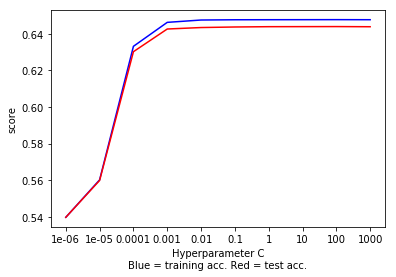

In [ ]:
import matplotlib.pyplot as plt
result_set = cv.cv_results_
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

# 3. Feature selection

In [ ]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 159
Number of features after elimination 82


In [ ]:
#GridsearchCV on reduced set
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

optimal_rfe_model = rfe_cv.best_estimator_

In [ ]:
X_reduced = pd.DataFrame()
for i in range(len(rfe.support_)):
    if rfe.support_[i]==True:
        X_reduced[X.iloc[:,i].name]=X.iloc[:,i]
model_repr(X_reduced,X_train_sel, X_test_sel, y_train, y_test,optimal_rfe_model,3)
print("Best paramter: ",rfe_cv.best_params_)


e)  3 most important variables: 
    1 / discharge_disposition_id_11 : -0.5627695729991069
    2 / number_inpatient : 0.5210915859413436
    3 / number_emergency : 0.2364296325825353
f) Train accuracy: 0.6460978032895464
   Test accuracy: 0.6449452672247263
              precision    recall  f1-score   support

           0     0.6401    0.7818    0.7039      8382
           1     0.6544    0.4845    0.5568      7148

    accuracy                         0.6449     15530
   macro avg     0.6472    0.6331    0.6303     15530
weighted avg     0.6467    0.6449    0.6362     15530

Best paramter:  {'C': 0.01}


# 4. Performance analysis

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred_proba_lr_1 = default_model.predict_proba(X_test)
y_pred_proba_lr_2 = optimal_model.predict_proba(X_test)
y_pred_proba_lr_3 = optimal_rfe_model.predict_proba(X_test_sel)

roc_index_lr_1 = roc_auc_score(y_test, y_pred_proba_lr_1[:, 1])
roc_index_lr_2 = roc_auc_score(y_test, y_pred_proba_lr_2[:, 1])
roc_index_lr_3 = roc_auc_score(y_test, y_pred_proba_lr_3[:, 1])

print("ROC index on test for LR with default setting:", roc_index_lr_1)
print("ROC index on test for LR with gridsearch:", roc_index_lr_2)
print("ROC index on test for LR with RFE and gridsearch:", roc_index_lr_3)

from sklearn.metrics import roc_curve

fpr_lr_1, tpr_lr_1, thresholds_lr_1 = roc_curve(y_test, y_pred_proba_lr_1[:,1])
fpr_lr_2, tpr_lr_2, thresholds_lr_2 = roc_curve(y_test, y_pred_proba_lr_2[:,1])
fpr_lr_3, tpr_lr_3, thresholds_lr_3 = roc_curve(y_test, y_pred_proba_lr_3[:,1])

ROC index on test for LR with default setting: 0.6965808347410051
ROC index on test for LR with gridsearch: 0.6965829878078335
ROC index on test for LR with RFE and gridsearch: 0.6964971238365261


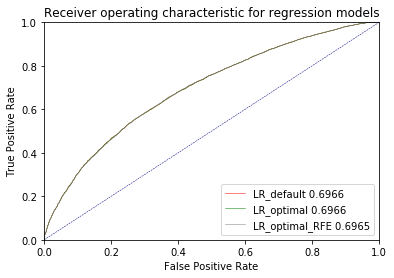

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fpr_lr_1, tpr_lr_1, label='LR_default {:.4f}'.format(roc_index_lr_1), color='red', lw=0.5)
plt.plot(fpr_lr_2, tpr_lr_2, label='LR_optimal {:.4f}'.format(roc_index_lr_2), color='green', lw=0.5)
plt.plot(fpr_lr_3, tpr_lr_3, label='LR_optimal_RFE {:.4f}'.format(roc_index_lr_3), color='gray', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for regression models')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Enter your code
import pickle
lr_best = cv
roc_index_lr_best = roc_index_lr_2
tpr_lr_best = tpr_lr_2
fpr_lr_best = fpr_lr_2
with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)